<a href="https://colab.research.google.com/github/Chood16/DSCI222/blob/main/lectures/(15)_PyTorch_Workflow_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow Fundamentals

The essence of machine learning and deep learning is to take some data from the past, build an algorithm (like a neural network) to discover patterns in it and use the discovered patterns to predict the future.

While traditional machine learning relies on manually engineered features and simpler models such as decision trees or linear regressions, deep learning is a specialized branch that uses multi-layered neural networks capable of automatically learning complex, hierarchical representations of data. This allows deep learning models to handle large amounts of unstructured data such as images, audio, and text with exceptional accuracy.

There are many ways to do this and many new ways are being discovered all the time. But let's start small and work to reproduce an example we already have worked with from traditional machine learning.

How about we start with a straight line?

And we see if we can build a PyTorch model that learns the pattern of the straight line and matches it.

Here is what we previously did to predict housing prices using Linear Regression

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [ ]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

# Load California housing dataset
housing = fetch_california_housing()

# Create DataFrames
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.DataFrame(housing.target, columns=housing.target_names)

# Display first rows
display(X.head())
display(y.head())

# Scale the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Display scaled features
display(X_scaled.head())



In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [ ]:
# Create an instance of Elastic Net Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train.MedHouseVal)

print(linreg.coef_)
print(linreg.intercept_)

In [ ]:
y_pred = linreg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

## What with this look like if we create a Neural Network instead?

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png" width=900 alt="a pytorch workflow flowchat"/>

For now, we'll use this workflow to predict a simple straight line like we did with Scikit-Learn, but the workflow steps can be repeated and changed depending on the problem you're working on.

Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **1. Getting data ready** | Data can be almost anything but to get started we're going to create a simple straight line |
| **2. Building a model** | Here we'll create a model to learn patterns in the data, we'll also choose a **loss function**, **optimizer** and build a **training loop**. |
| **3. Fitting the model to data (training)** | We've got data and a model, now let's let the model (try to) find patterns in the (**training**) data. |
| **4. Evaluate model (inference)** | Our model's found patterns in the data, let's compare its findings to the actual (**testing**) data. |
| **5. Putting it all together** | Let's take all of the above and combine it. |

And now let's import what we'll need for this module.

We're going to get `torch`, `torch.nn` (`nn` stands for neural network and this package contains the building blocks for creating neural networks in PyTorch) and `matplotlib`.

In [ ]:
import pandas as pd
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


## 1. Data (preparing and loading)

I want to stress that "data" in machine learning can be almost anything you can imagine. A table of numbers (like a big Excel spreadsheet), images of any kind, videos (YouTube has lots of data!), audio files like songs or podcasts, protein structures, text and more. While machine learning is great for structured and semistructured data, Neural Networks and Deeper Learning are ideal for unstructured data.

![machine learning is a game of two parts: 1. turn your data into a representative set of numbers and 2. build or pick a model to learn the representation as best as possible](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-machine-learning-a-game-of-two-parts.png)

Machine learning is a game of two parts:
1. Turn your data, whatever it is, into numbers (a representation).
2. Pick or build a model to learn the representation as best as possible.


### Split data into training and test sets

We've got some data. But before we build a model we need to split it up.

Each split of the dataset serves a specific purpose:

| Split | Purpose | Amount of total data | How often is it used? |
| ----- | ----- | ----- | ----- |
| **Training set** | The model learns from this data (like the course materials you study during the semester). | ~60-80% | Always |
| **Validation set** | The model gets tuned on this data (like the practice exam you take before the final exam). | ~10-20% | Often but not always |
| **Testing set** | The model gets evaluated on this data to test what it has learned (like the final exam you take at the end of the semester). | ~10-20% | Always |


In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, random_split
import torch

# 1. Load dataset
housing = fetch_california_housing()
X = housing.data
y = housing.target

# 2. Scale features <-- we'll see as well what happens when we skip this step
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# X_scaled = X

# 3. Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1) # <-- PyTorch layers expect targets to be 2D

# 4. Wrap tensors in a dataset
dataset = TensorDataset(X_tensor, y_tensor)

# 5. Split into train/test sets <-- This replaces the train_test_split from Scikit-Learn
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(train_dataset[:])
print(test_dataset[:])


In [ ]:
X_train = train_dataset[:][0]
print(X_train.shape)
y_train = train_dataset[:][1]
print(y_train.shape)
X_test = test_dataset[:][0]
print(X_test.shape)
y_test = test_dataset[:][1]
print(y_test.shape)

# Now our features are scaled and our data is split, we are ready for training


The model we create is going to try and learn the relationship between `X_train` & `y_train` and then we will evaluate what it learns on `X_test` and `y_test`.

## 2. Build model

Now we've got some data, let's build a model to replicate a standard linear regression model using pure PyTorch.

### PyTorch model building essentials

PyTorch has four essential modules you can use to create almost any kind of neural network you can imagine.

They are [`torch.nn`](https://pytorch.org/docs/stable/nn.html), [`torch.optim`](https://pytorch.org/docs/stable/optim.html), [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html). For now, we'll focus on the first two and get to the other two later (time permitting).

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html))  are calculated automatically, this is often referred to as "autograd".  |
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. |
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). |
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above). |

If the above sounds complex, think of like this, almost everything in a PyTorch neural network comes from `torch.nn`,
* `nn.Module` contains the larger building blocks (layers)
* `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`(s))
* `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within  `nn.Module`(s)
* `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data

*Basic building blocks of creating a PyTorch model by subclassing `nn.Module`. For objects that subclass `nn.Module`, the `forward()` method must be defined.*

> **Resource:** See more of these essential modules and their use cases in the [PyTorch Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html).


In [ ]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() # <-- super() refers to the superclass, which is nn.Module
                           # <-- calls the nn.Module constructor (__init__)
                           # <-- gives the LinearRegressionModel object the attributes and methods defined in nn.Module

        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=8,
                                      out_features=1)

    # Define the forward computation
    # forward() defines how data flows through your model through our nn.Linear() layer

    def forward(self, x): # <- "x" is the input data (e.g. training/testing features)
        return self.linear_layer(x)



### Create an instance of our model

In [ ]:
# Set the manual seed when creating the model for example purposes
torch.manual_seed(42)

# Create an instance of our model
model_0 = LinearRegressionModel()


### Checking the contents of a PyTorch model
Let's check out the `LinearRegressionModel` parameters using [`.parameters()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters).


In [ ]:
print(list(model_0.parameters()))


We can also get the state (what the model contains) of the model using .`state_dict()`.

In [ ]:
print(model_0.state_dict())

These weights and bias look nothing like what we got from our Scikit example. That's because these are the "random" starting values of our model. Notice, no training data has been put into our model yet. As we put our training data into our model, these values will improve.

In [ ]:
# Weights and bias from Scikit-Learn example

print(linreg.coef_) # <-- weights
print(linreg.intercept_) # <-- bias

Notice how the values for `weights` and `bias` from `model_0.state_dict()` come out as random float tensors?

This is because we initialized them above using `torch.Linear()`. Remember Kaiming uniform initialization?

Essentially we want to start from random parameters and get the model to update them towards parameters that fit our data best (ideally these results will match what we found from using Linear Regression originally).

Because our model starts with random values, right now it'll have poor predictive power.



### Making predictions using `torch.inference_mode()`

Let's make some predictions based on our current model. We'd expect these to be terrible, given the parameters are random and have not yet been trained.

In [ ]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

You probably noticed we used `torch.inference_mode()`to make the predictions.

As the name suggests, `torch.inference_mode()` is used when using a model for inference (making predictions).

`torch.inference_mode()` turns off a bunch of things used for training (like gradient tracking) to make it more efficient.

We've made some predictions, let's see what they look like.

In [ ]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

In [ ]:
y_test - y_preds



In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_preds)
print("Mean Absolute Error:", mae)


Woah! Those predictions look pretty bad...

This makes sense though, when you remember our model is just using random parameter values to make predictions.

## 3. Train model

Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

To fix that, we can update its internal parameters (`weights` and `bias`) to be something that better represents the data.



### Creating a loss function and optimizer in PyTorch

For our model to update its parameters on its own, we'll need to add a **loss function** as well as an **optimizer**.

| Component         | Purpose                                                              | PyTorch Location                                                     | Examples                                                                                                                                                                                                                  |
| ----------------- | -------------------------------------------------------------------- | -------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Loss function** | Measures how wrong predictions are vs. true labels. Lower is better. | [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions) | - Regression: MAE → [`nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) <br> <br>- Binary classification: BCE → [`nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) |
| **Optimizer**     | Updates model parameters to reduce loss                              | [`torch.optim`](https://pytorch.org/docs/stable/optim.html)          | - SGD → [`optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) <br> <br>- Adam → [`optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)                                   |


Let's create a loss function and an optimizer we can use to help improve our model.

Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

* MAE (mean absolute error) loss function is common for regression problems (predicting a number)

* Binary cross entropy loss function for classification problems (predicting one thing or another)

* SGD (stochastic gradient descent) and Adam optimizer are both commonly used optimizers

For our problem, since we're predicting a number, let's use MAE (which is under `torch.nn.L1Loss()`) in PyTorch as our loss function.

![what MAE loss looks like for our plot data](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-mae-loss-annotated.png)
*Mean absolute error (MAE, in PyTorch: `torch.nn.L1Loss`) measures the absolute difference between two points (predictions and labels) and then takes the mean across all examples.*

We'll also use SGD, `torch.optim.SGD(params, lr)` as our loss function:

* `params` is the target model parameters you'd like to optimize (e.g. the `weights` and `bias` values we randomly set before).
* `lr` is the **learning rate** you'd like the optimizer to update the parameters at. Think of it as the size of steps taken during each run through of the network.
  * Higher means the optimizer will try larger updates
  * Lower means the optimizer will try smaller updates.
  * The learning rate is considered a **hyperparameter** because it's set by a machine learning engineer.
  * Common starting values for the learning rate are `0.01`, `0.001`, `0.0001`, however, these can also be adjusted over time (this is called [learning rate scheduling](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)).

In [ ]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

### Creating an optimization loop in PyTorch

Now we've got a loss function and an optimizer, it's now time to create a **training loop** (and **testing loop**).

The training loop involves the model going through the training data and learning the relationships between the `features` and `labels`.

The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never sees the testing data during training).

Each of these is called a "loop" because we want our model to look (loop through) at each sample in each dataset.

There will be a fair bit of code but nothing we can't handle.




### PyTorch training loop
For the training loop, we'll build the following steps:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass |  Go through our model with the `x_train` data, performing its `forward()` function calculations. | `model(x_train)` |
| 2 | Calculate the loss | Compare the model's outputs to our labels and see how wrong they are. | `loss = loss_fn(y_pred, y_train)` |
| 3 | Zero gradients | Set the optimizer gradients to zero so they can be recalculated for the current training step. | `optimizer.zero_grad()` |
| 4 | Perform backpropagation on the loss | Compute the gradient of the loss for every model parameter.| `loss.backward()` |
| 5 | Update the optimizer (**gradient descent**) | Update the parameters with respect to the loss gradients| `optimizer.step()` |


Let's put all of the above together and train our model for 1000 **epochs** (forward passes through the data) and we'll evaluate it every 100 epochs.



In [ ]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 1001

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero gradients
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    # Print out what's happening
    if epoch % 100 == 0:
      epoch_count.append(epoch)
      train_loss_values.append(loss.detach())
      print(f"Epoch: {epoch} | MAE Train Loss: {loss.detach()}")

Looks like our loss is going down with every epoch, let's plot it to find out how many epochs we really needed.

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

The **loss curve** shows the loss going down over time. Remember, loss is the measure of how *wrong* your model is, so the lower the better.

Why did the loss go down?

Thanks to our loss function and optimizer, the model's internal parameters (`weights` and `bias`) were updated to better reflect the underlying patterns in the data.

What would have happened if we didn't normalize our data before doing this?



In [ ]:
# View the entire parameter
weights = model_0.linear_layer.weight
print(weights)

In [ ]:
# Detach the values
weights = model_0.linear_layer.weight.detach()
print(weights)

In [ ]:
# Reduce dimensions
weights = model_0.linear_layer.weight.detach().squeeze()
print(weights)

In [ ]:
# Make a list
weights = model_0.linear_layer.weight.detach().squeeze().tolist()
print(weights)

In [ ]:
import pandas as pd

# PyTorch parameters
weights = model_0.linear_layer.weight.detach().squeeze().tolist()
bias = model_0.linear_layer.bias.item()

# Create a table
data = {
    "PyTorch": weights + [bias],
    "scikit-learn": linreg.coef_.tolist() + [linreg.intercept_]
}

df = pd.DataFrame(data, index=[f"Feature {i}" for i in range(len(weights))] + ["Bias"])

display(df)


Our model got very close to our Scikit-Learn `weight` and `bias` parameters!

It'd likely never guess them *perfectly* (especially when using more complicated datasets) but that's okay, often you can do very cool things with a close approximation.

This is the whole idea of machine learning and deep learning, **there are some ideal values that describe our data** and rather than figuring them out by hand, **we can train a model to figure them out programmatically**.

## 4. Evaluate model (inference)

Once you've trained a model, you'll want to validate it by using your testing data. This can give you confidence in future predictions the model is used to make

We've already seen a glimpse of this in the training loop above, the steps for the testing are similar. In practice, you will often train and test in a single loop together. For this example, we are separating them to better see what each does.

There are three things to remember when making predictions (also called performing inference) for your testing data with a PyTorch model:

1. Set the model in evaluation mode (`model.eval()`).
2. Make the predictions using the inference mode context manager (`with torch.inference_mode():`).
3. All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

The first two items make sure all helpful calculations and settings PyTorch uses behind the scenes during training but aren't necessary for inference are turned off (this results in faster computation). And the third ensures that you won't run into cross-device errors.

To keep it simple, we will only worry about steps one and two for now.


### PyTorch testing

As for the testing (evaluating our model), the typical steps include:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | Go through our model with the `x_test` data, performing its `forward()` function calculations. | `model(x_test)` |
| 2 | Calculate the loss | Compare the model's outputs to our labels and see how wrong they are. | `loss = loss_fn(y_pred, y_test)` |
| 3 | Additional evaluation metrics (optional) | Alongside the loss value you may want to calculate other evaluation metrics such as accuracy on the test set. | Custom functions |

Notice the testing loop doesn't contain performing backpropagation (`loss.backward()`) or stepping the optimizer (`optimizer.step()`), this is because no parameters in the model are being changed during testing, they've already been calculated. For testing, we're only interested in the output of the forward pass through the model.



In [ ]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  y_preds = model_0(X_test)


In [ ]:
display(y_preds)
test_loss = loss_fn(y_preds, y_test)
print(f"MAE Test Loss: {test_loss.detach()}")

## 5. Putting it all together

Let's put everything we've done so far together.

Except this time we'll make our code device agnostic (so if there's a GPU available, it'll use it and if not, it will default to the CPU).

> **Note:** To setup a GPU, go to Runtime -> Change runtime type -> Hardware acceleration -> GPU. If you do this, it will reset the Colab runtime and you will lose saved variables.

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, random_split
import pandas as pd

# Check PyTorch version
torch.__version__

Now let's start making our code device agnostic by setting `device="cuda"` if it's available, otherwise it'll default to `device="cpu"`.



In [ ]:
# Setup device agnostic code
set_device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {set_device}")

If you've got access to a GPU, the above should've printed out:

```
Using device: cuda
```
Otherwise, you'll be using a CPU for the following computations. This is fine for our small dataset but it will take longer for larger datasets.

### 5.1 Data

In [ ]:
# 1. Load dataset
housing = fetch_california_housing()
X = housing.data
y = housing.target

# 2. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# 4. Wrap tensors in a dataset
dataset = TensorDataset(X_tensor, y_tensor)

# 5. Split into train/test sets
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

### 5.2 Building a PyTorch linear model


In [ ]:
# Create a Linear Regression model class
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=8,
                                      out_features=1)

    def forward(self, x):
        return self.linear_layer(x)

In [ ]:
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

Now let's put our model on the GPU.

We can change the device our PyTorch objects are on using .to(device).

First let's check the model's current device.

In [ ]:
# Check model device
next(model_1.parameters()).device

Looks like the model's on the CPU by default.

In [ ]:
# Set model to GPU if it's available, otherwise it'll default to CPU
model_1.to(set_device)

# Check model device... again
next(model_1.parameters()).device

### 5.3 Training/Testing

In [ ]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [ ]:
# Set the number of epochs
epochs = 301

# Put data on the available device
# The model AND data must be on the same device
X_train = X_train.to(set_device)
X_test = X_test.to(set_device)
y_train = y_train.to(set_device)
y_test = y_test.to(set_device)

for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval()
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 25 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

In [ ]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
display(model_1.state_dict())


If you're making predictions with data on the GPU, you might notice the output of the above has `device='cuda:0'` towards the end. That means the data is on CUDA device 0 (the first GPU your system has access to due to zero-indexing), if you end up using multiple GPUs in the future, this number may be higher.

> **Note:** Many data science libraries such as pandas, matplotlib and NumPy aren't capable of using data that is stored on GPU. So you might run into some issues when trying to use a function from one of these libraries with tensor data not stored on the CPU. To fix this, you can call [`.cpu()`](https://pytorch.org/docs/stable/generated/torch.Tensor.cpu.html) on your target tensor to return a copy of your target tensor on the CPU.

## 6. More on Layers

So far, we have worked with one of the simplest types of NN, mimicing linear regression. In practice, networks have many layers of different types.


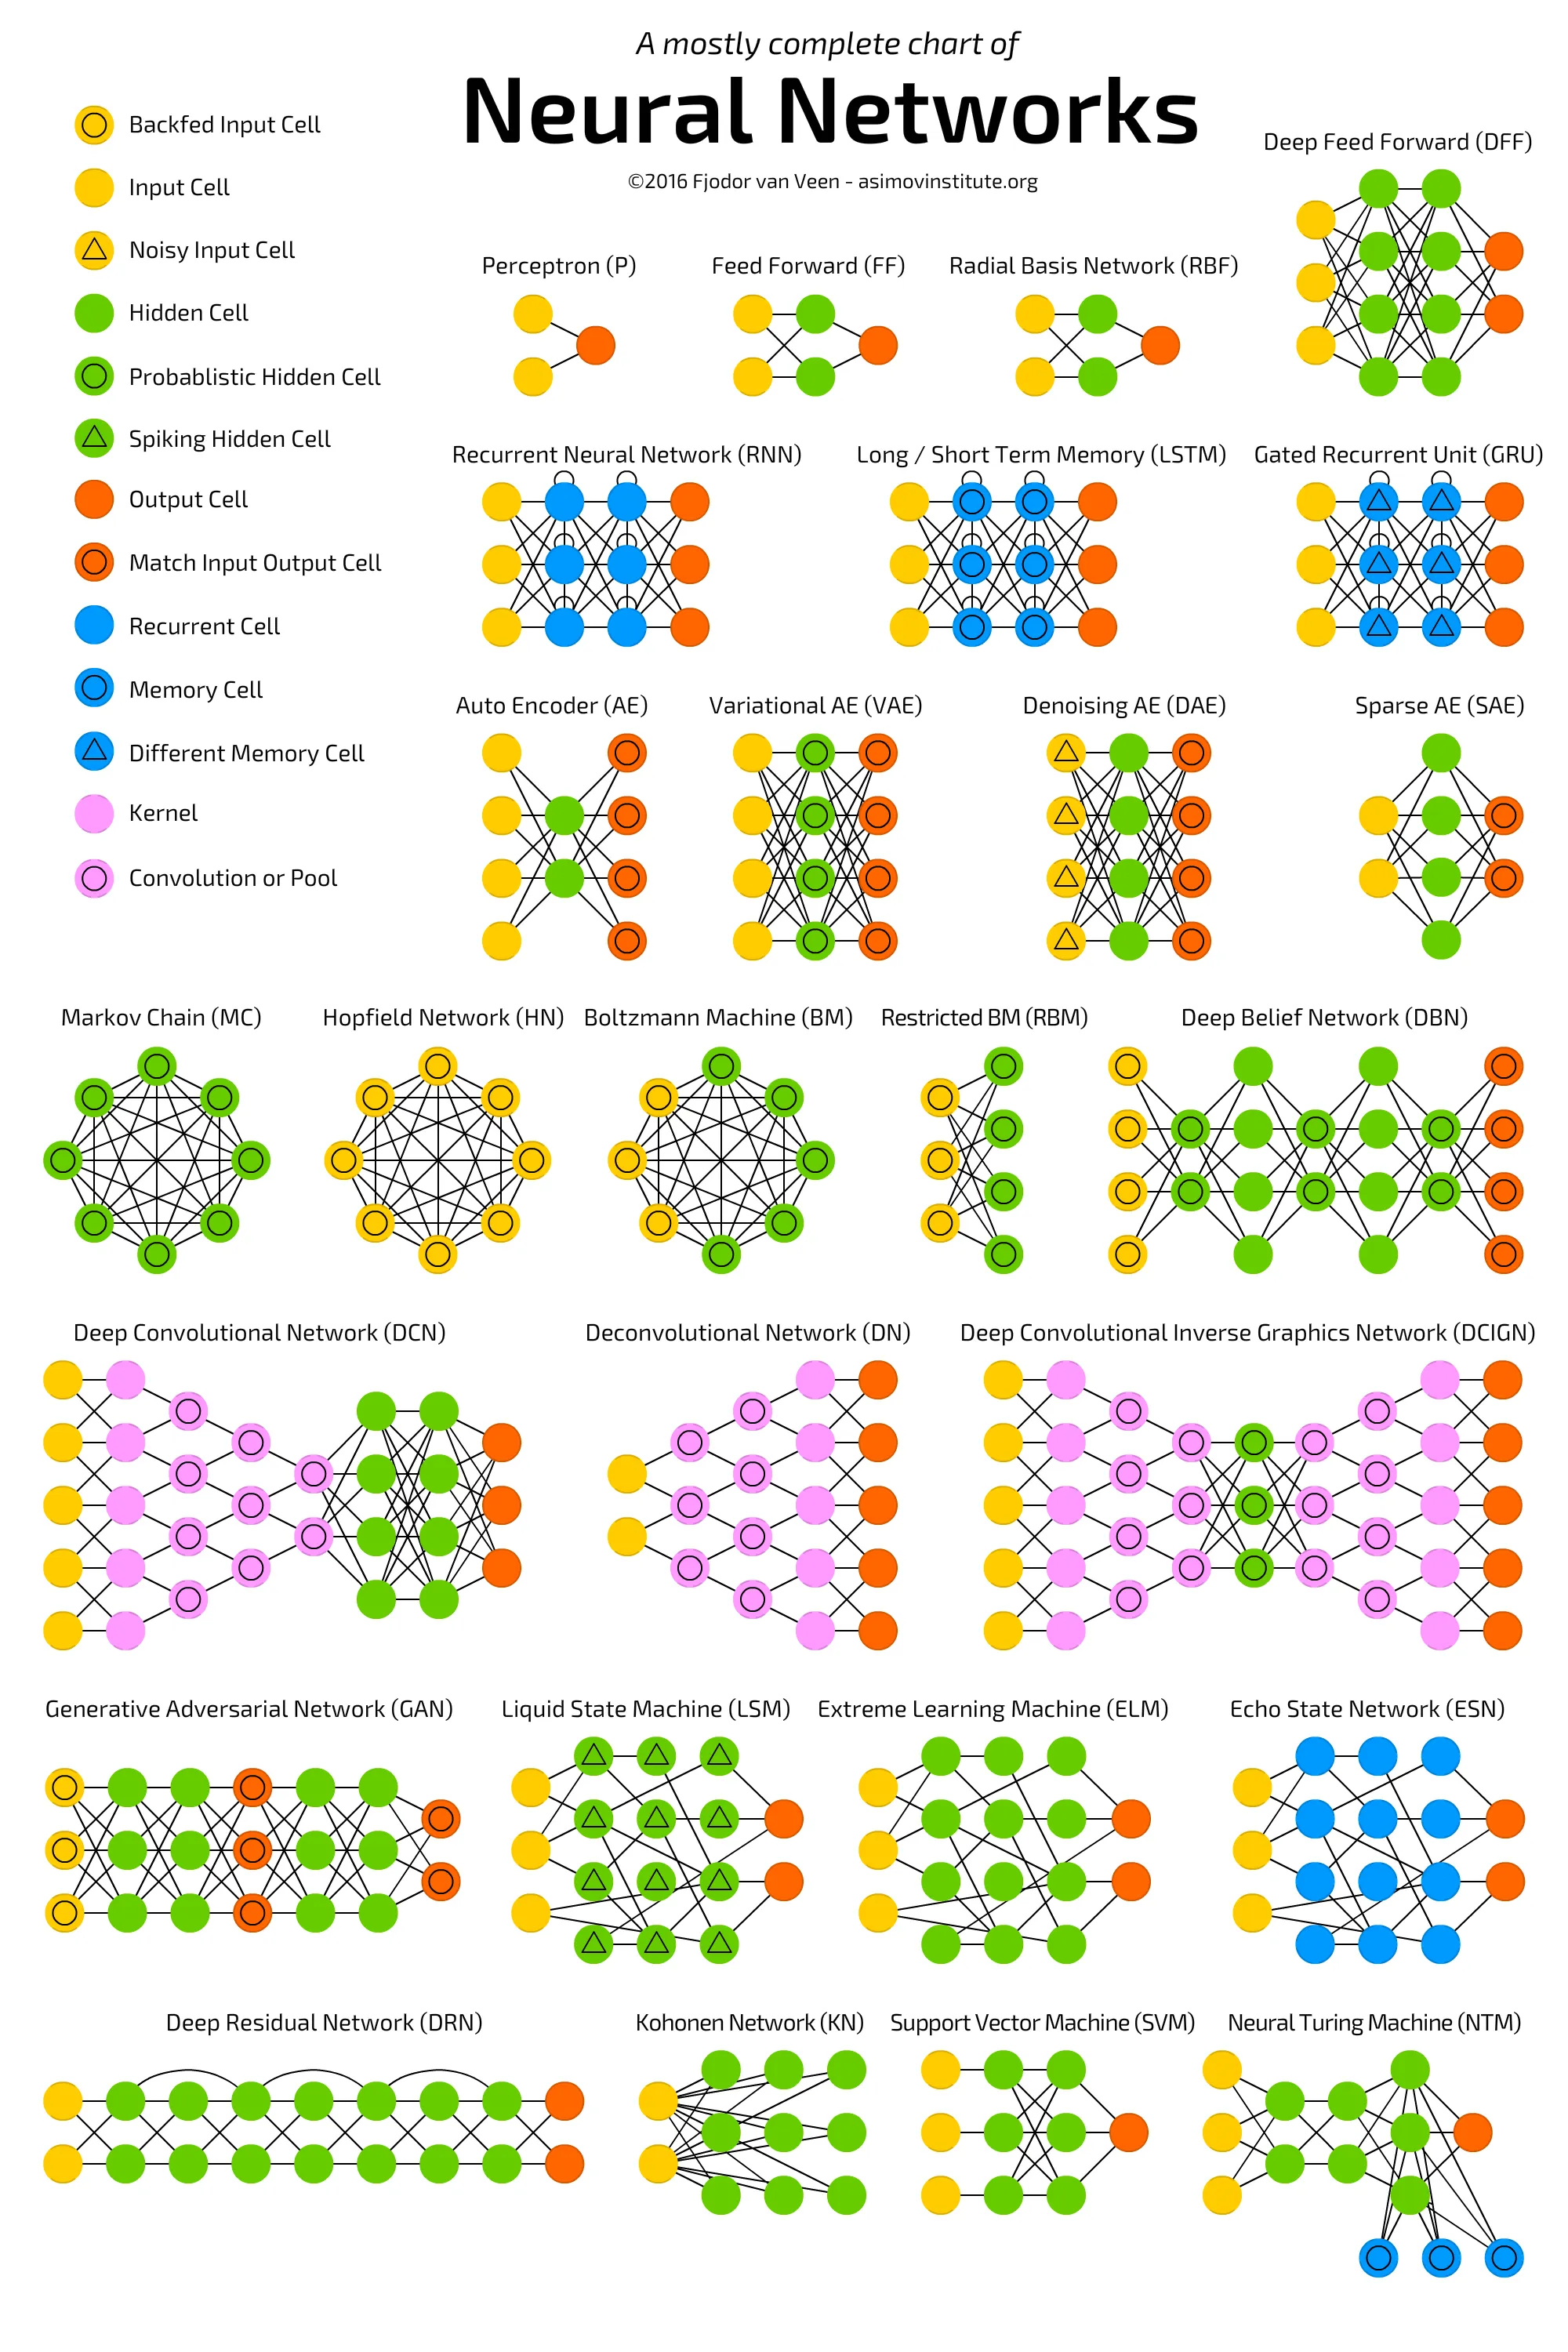

Some additional things that are good to know about neural networks:

| Term                 | What it is                                                | Purpose / Why we use it                                                               |
| -------------------- | --------------------------------------------------------- | ------------------------------------------------------------------------------------- |
| **Neuron**           | Single computational unit in a layer                      | Each node in every layer is called a Nueron |
| **`nn.Sequential`**                  | Sequential container of layers                            | Allows stacking layers in order without writing an explicit `forward()` function                        |
| **Activation function**              | Non-linear function applied to layer outputs              | Allows networks to approximate complex functions; examples: ReLU, Sigmoid, Tanh                         |
| **`nn.ReLU`**        | Rectified Linear Unit activation function                 | Introduces non-linearity; sets negative inputs to zero                                |
| **`nn.LeakyReLU`**   | Variant of ReLU                                           | Allows small gradients for negative inputs to prevent “dead neurons”                  |
| **Batch**            | A subset of the dataset used in one forward/backward pass | Makes training more efficient; allows gradient updates without using the full dataset               |
| **`nn.BatchNorm1d`** | Batch Normalization layer for 1D inputs                   | Normalizes layer outputs across the batch to stabilize and speed up training          |
| **`nn.Dropout`**     | Dropout layer                                             | Randomly sets a fraction of neurons to zero during training to prevent overfitting    |




In [ ]:
import torch
import torch.nn as nn

class ComplexNN_Sequential(nn.Module):
    def __init__(self, input_features=8):
        super().__init__()

        # ----------------------------
        # Layer 1 block: Input → Hidden1
        # ----------------------------
        self.block1 = nn.Sequential(
            nn.Linear(input_features, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # ----------------------------
        # Layer 2 block: Hidden1 → Hidden2
        # ----------------------------
        self.block2 = nn.Sequential(
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.2)
        )

        # ----------------------------
        # Layer 3 block: Hidden2 → Hidden3
        # ----------------------------
        self.block3 = nn.Sequential(
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # ----------------------------
        # Output layer
        # ----------------------------
        self.output_layer = nn.Linear(16, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block1(x)          # Pass through first block
        x = self.block2(x)          # Pass through second block
        x = self.block3(x)          # Pass through third block
        x = self.output_layer(x)    # Final output
        return x
